In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization, Activation
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import class_weight
import keras
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 224

IMG_DIR = '../project/eval_data/all_females_combined_train_e'
RATING_PATH = '../project/eval_data/all_females_combined_train_e/train_ratings.txt'

TEST_IMG_DIR = '../project/eval_data/all_females_combined_test_e'
TEST_RATING_PATH = '../project/eval_data/all_females_combined_test_e/test_ratings.txt'

VERSION = 'eval-OrdReg-comb-BN-A'

In [3]:
def getMean(train_data):
    #calculate mean values for pixels (RGB)

    data = np.zeros((train_data.shape[0], IMG_SIZE, IMG_SIZE, 3)) 
    for i in range(train_data.shape[0]):
        _img = image.load_img(os.path.join(IMG_DIR, train_data[i]), target_size=(IMG_SIZE,IMG_SIZE))
        data[i,:,:,:] = image.img_to_array(_img)
    mean = np.mean(data, axis=(0, 1, 2))
    print("Pixel means: ",mean)

    return mean

In [4]:
def preprocess(x,mean):
    x[:,:,0] -= mean[0]
    x[:,:,1] -= mean[1]
    x[:,:,2] -= mean[2]

In [5]:
def prepareDataRegression(percentage):
    # Read in ratings
    ratings = np.genfromtxt(RATING_PATH)
        
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    

    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1)
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1)
            last_set_train += 1
    
    return data_train, ratings[train_ind], data_test, ratings[test_ind], ratings, images[test_ind], mean

In [6]:
def prepareDataClassification(percentage):
    # Read in ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Round (obviously imbalanced sets)
    ratings_rounded = np.round(ratings, 0).astype(np.int8)
    ratings = to_categorical(ratings_rounded, num_classes=len(np.unique(ratings)))
    
                
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1)
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1)
            last_set_train += 1
    
    return data_train, ratings[train_ind], data_test, ratings[test_ind], ratings_rounded, images[test_ind], mean

In [7]:
def prepareDataOrdinalRegression(percentage):
    # Load ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    print(len(ratings))
    print(len(images))
    assert len(ratings) == len(images)
    
    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1)
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1)
            last_set_train += 1
    
    
    return data_train, ratings_prepared[train_ind], data_test, ratings_prepared[test_ind], ratings_rounded, images[test_ind], mean

In [8]:
def getGenerator(data_train, data_test):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
                                      )

    train_datagen.fit(data_train)
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(data_test)

    return train_datagen, test_datagen

In [9]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def visualize_acc(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training acc")
    plt.plot(epochs, val_loss, 'r', label="Validation acc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [11]:
def visualize_mae(history):
    loss = history.history['mean_absolute_error']
    val_loss = history.history['val_mean_absolute_error']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training mean_absolute_error")
    plt.plot(epochs, val_loss, 'r', label="Validation mean_absolute_error")
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [12]:
def recommend(images, pred_classes):
    if type(images) is np.ndarray: 
        images = images.tolist()
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

def recommendTest(images, pred_classes):
    if type(images) is np.ndarray: 
        images = images.tolist()
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(TEST_IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

### Get data

In [13]:
x_train, y_train, x_val, y_val, ratings, images_val, mean = prepareDataOrdinalRegression(5)
train_generator, test_generator = getGenerator(x_train,x_val)

train_inst = x_train.shape[0]
print("x_train: ",x_train.shape)
print("y_train: ",y_train.shape)
print("x_val: ",x_val.shape)
print("y_val: ",y_val.shape)
print("ratings",ratings.shape)


676
676
Pixel means:  [161.73091496 134.54709699 120.57198865]
x_train:  (643, 224, 224, 3)
y_train:  (643, 6)
x_val:  (33, 224, 224, 3)
y_val:  (33, 6)
ratings (676,)


### Build keras model

In [14]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation=None, name='fc6')(last_layer)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(128, activation=None, name='fc7')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation=None, name='fc8')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(len(np.unique(ratings)), activation=None)(X)
X = BatchNormalization()(X)
output = Activation('sigmoid')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False
    
# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

model.compile(optimizer=Adam(lr= 0.0005,clipnorm=1.0),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./weights-' + VERSION + '.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [15]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=train_inst//32,
    epochs=500,
    class_weight=class_weight,
    validation_data=test_generator.flow(x_val, y_val, batch_size=32),
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
20/20 [==============================] - 13s 642ms/step - loss: 0.8011 - acc: 0.5100 - val_loss: 0.7578 - val_acc: 0.4798

Epoch 00001: val_loss improved from inf to 0.75785, saving model to ./weights-eval-OrdReg-comb-BN-A-orig.hdf5
Epoch 2/500
20/20 [==============================] - 8s 396ms/step - loss: 0.7746 - acc: 0.5232 - val_loss: 0.7192 - val_acc: 0.5404

Epoch 00002: val_loss improved from 0.75785 to 0.71919, saving model to ./weights-eval-OrdReg-comb-BN-A-orig.hdf5
Epoch 3/500
20/20 [==============================] - 8s 396ms/step - loss: 0.7682 - acc: 0.5358 - val_loss: 0.7090 - val_acc: 0.5202

Epoch 00003: val_loss improved from 0.71919 to 0.70903, saving model to ./weights-eval-OrdReg-comb-BN-A-orig.hdf5
Epoch 4/500
20/20 [==============================] - 8s 395ms/step - loss: 0.7563 - acc: 0.5400 - val_loss: 0.7169 - val_acc: 0.5051

Epoch 00004: val_loss did not improve
Epoch 5/500
20/20 [==============================] - 8s 395ms/step - loss: 0.7542 - acc

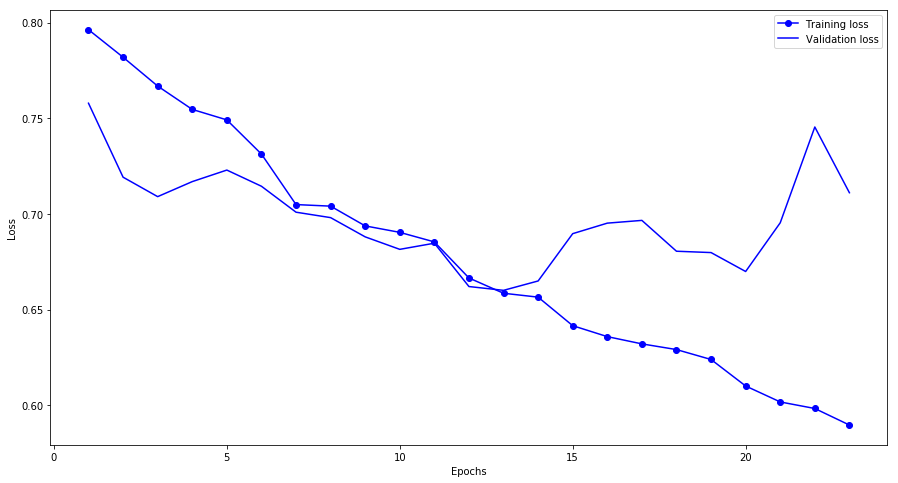

In [16]:
visualize_loss(history)

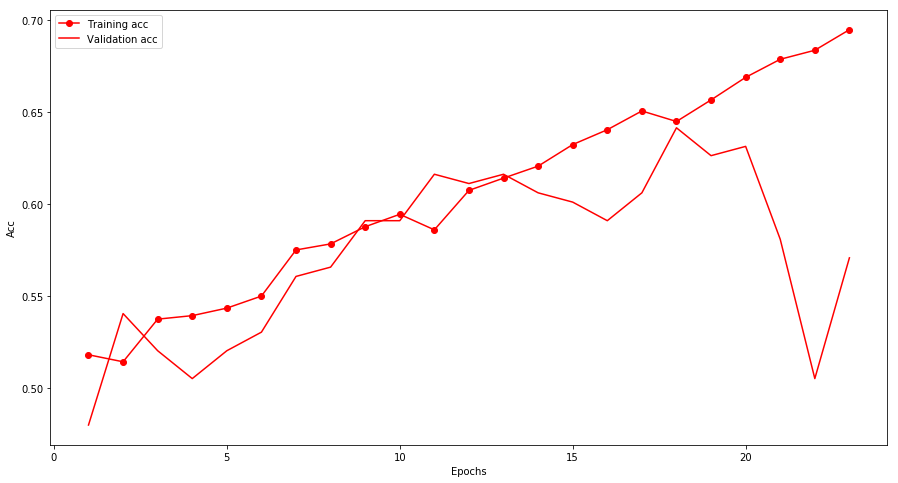

In [17]:
visualize_acc(history)

In [18]:
model.save('./models/love_classifier' + VERSION + '.h5')

### Predictions: Validation set

In [19]:
predictions = model.predict(x_val)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)

y_true = np.array(y_val).sum(axis=-1).astype(np.int8)
print(y_true)
print(pred_classes)
print(len(pred_classes))

confusion_matrix(y_true,pred_classes)

[0 5 4 4 0 0 3 0 0 1 5 0 0 3 0 2 1 0 2 1 5 0 2 4 0 0 3 1 2 0 0 2 1]
[0 0 0 4 0 2 2 3 0 1 1 3 2 1 4 4 0 1 0 6 0 1 3 6 2 4 1 4 2 1 5 2 3]
33


array([[3, 3, 3, 2, 2, 1, 0],
       [1, 1, 0, 1, 1, 0, 1],
       [1, 0, 2, 1, 1, 0, 0],
       [0, 2, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 1],
       [2, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

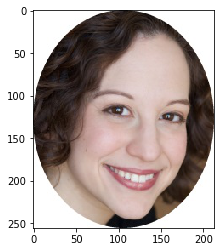

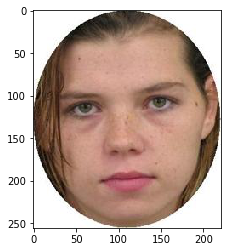

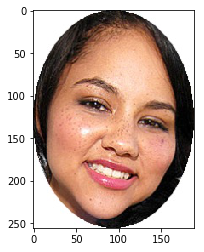

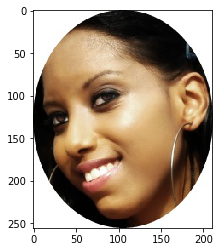

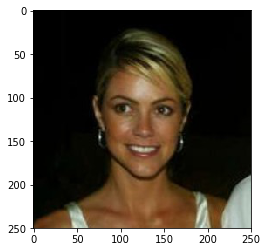

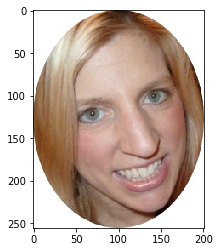

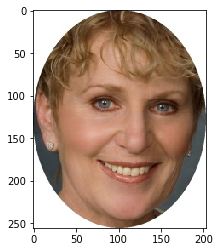

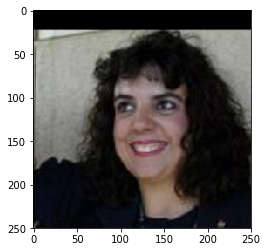

In [20]:
recommend(images_val,pred_classes)

### Prediction: Test set

In [21]:
def prepareTestDataRegression():
    # Read in ratings
    ratings = np.genfromtxt(TEST_RATING_PATH)
        
    ### Move all images according to ratings
    images = sorted(os.listdir(TEST_IMG_DIR))
    #remove test_ratings.txt from images
    images.remove('test_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images):
        _img = image.load_img(os.path.join(TEST_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = utils.preprocess_input(_x, version=1)
        last_set += 1
    
    return data, images, ratings

In [22]:
def prepareTestDataClassification():
    # Read in ratings
    ratings = np.genfromtxt(TEST_RATING_PATH)
    
    # Round (obviously imbalanced sets)
    ratings_rounded = np.round(ratings, 0).astype(np.int8)
    ratings = to_categorical(ratings_rounded, num_classes=len(np.unique(ratings_rounded)))
    
                
    ### Move all images according to ratings
    images = sorted(os.listdir(TEST_IMG_DIR))
    #remove test_ratings.txt from images
    images.remove('test_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images): #iterate over images
        _img = image.load_img(os.path.join(TEST_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = utils.preprocess_input(_x, version=1)
        last_set += 1
    
    return data, images, ratings

In [23]:
def prepareTestDataOrdinalRegression():
    # Load ratings
    ratings = np.genfromtxt(TEST_RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(TEST_IMG_DIR))
    #remove test_ratings.txt from images
    images.remove('test_ratings.txt')

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)
    
    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images): 
        _img = image.load_img(os.path.join(TEST_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = utils.preprocess_input(_x, version=1)
        last_set += 1
    
    return data, images, ratings_prepared

In [24]:
x_test, images_test, ratings_test = prepareTestDataOrdinalRegression()

predictions = model.predict(x_test)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)


y_true = np.array(ratings_test).sum(axis=-1).astype(np.int8)
print(y_true)
print(pred_classes)
print(len(pred_classes))

confusion_matrix(y_true,pred_classes)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5]
[1 3 4 3 3 4 4 1 4 4 4 5 2 4 5 2 2 3 1 0 5 3 0 4 1 0 1 6 2 5 5 2 5 4 2 1 2
 4 1 4 3 0]
42


array([[0, 1, 0, 3, 3, 0, 0],
       [0, 1, 1, 0, 4, 1, 0],
       [1, 1, 2, 1, 0, 2, 0],
       [2, 2, 0, 1, 1, 0, 1],
       [0, 0, 3, 0, 1, 3, 0],
       [1, 2, 1, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

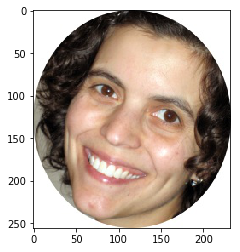

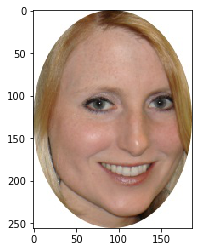

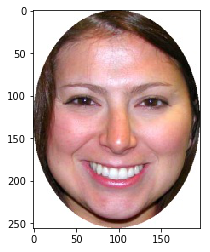

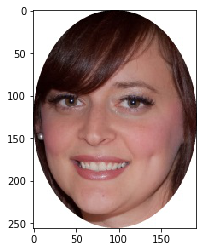

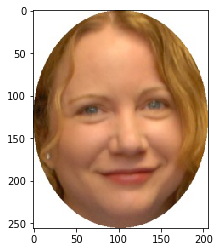

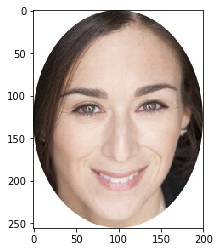

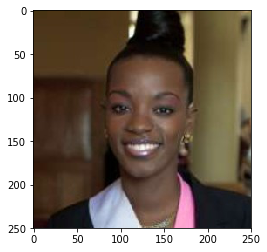

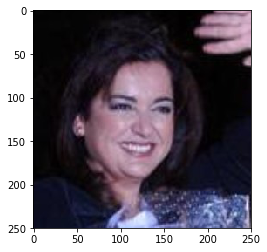

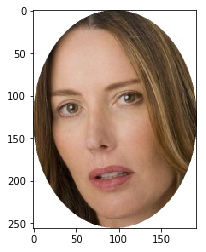

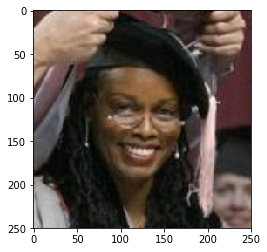

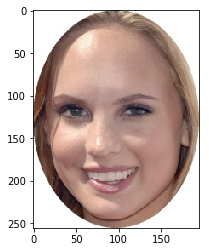

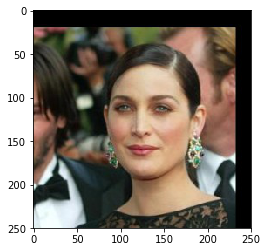

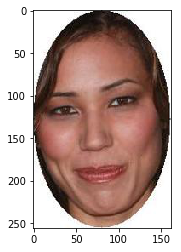

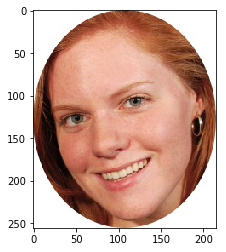

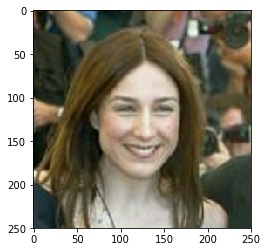

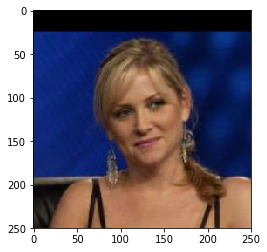

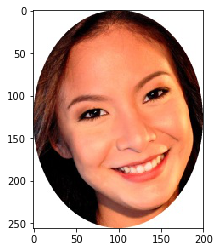

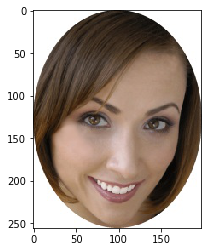

In [25]:
recommendTest(images_test,pred_classes)

In [26]:
model.evaluate(x_train,y_train)

643/643 [==============================] - 8s 12ms/step


[5.3391463046496614, 0.653965783434374]

In [27]:
predictions = model.predict(x_train)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)

y_true = np.array(y_train).sum(axis=-1).astype(np.int8)

print(len(pred_classes))
confusion_matrix(y_true,pred_classes)

643


array([[70, 57, 36, 18, 15,  7,  2],
       [32, 26, 25, 14, 22,  7,  4],
       [12, 13, 16, 11, 18,  8,  2],
       [ 3,  9, 15, 25, 19, 11,  7],
       [ 2,  2,  7, 14, 20, 11,  7],
       [ 0,  1,  9, 13, 23, 19, 11],
       [ 0,  0,  0,  0,  0,  0,  0]])

In [28]:
model.evaluate(x_val,y_val)

33/33 [==============================] - 0s 13ms/step


[6.931435657270027, 0.5505050511071177]